# Introduction to NeuralHydrology

**Before we start**

- This tutorial is rendered from a Jupyter notebook that is hosted on GitHub. If you want to run the code yourself, you can find the notebook and configuration files [here](https://github.com/neuralhydrology/neuralhydrology/tree/master/examples/01-Introduction).
- To be able to run this notebook locally, you need to download the publicly available CAMELS US rainfall-runoff dataset. See the [Data Prerequisites Tutorial](data-prerequisites.nblink) for a detailed description on where to download the data and how to structure your local dataset folder. You will also need to follow the [installation instructions](https://neuralhydrology.readthedocs.io/en/latest/usage/quickstart.html#installation) (the easiest option if you don't plan to implement your own models/datasets is `pip install neuralhydrology`; for other options refer to the installation instructions).

The Python package NeuralHydrology was was developed with a strong focus on research. The main application area is hydrology, however, in principle the code can be used with any data. To allow fast iteration of research ideas, we tried to develop the package as modular as possible so that new models, new data sets, new loss functions, new regularizations, new metrics etc. can be integrated with minor effort.

There are two different ways to use this package:

1. From the terminal, making use of some high-level entry points (such as `nh-run` and `nh-run-scheduler`)
2. From any other Python file or Jupyter Notebook, using NeuralHydrology's API

In this tutorial, we will give a very short overview of the two different modes.

Both approaches require a **configuration file**. These are `.yml` files which define the entire run configuration (such as data set, basins, data periods, model specifications, etc.). A full list of config arguments is listed in the [documentation](https://neuralhydrology.readthedocs.io/en/latest/usage/config.html) and we highly recommend to check this page and read the documentation carefully. There is a lot that you can do with this Python package and we can't cover everything in tutorials.

For every run that you start, a new folder will be created. This folder is used to store the model and optimizer checkpoints, train data means/stds (needed for scaling during inference), tensorboard log file (can be used to monitor and compare training runs visually), validation results (optionally) and training progress figures (optionally, e.g., model predictions and observations for _n_ random basins). During inference, the evaluation results will also be stored in this directory (e.g., test period results).


### TensorBoard logging
By default, the training progress is logged in TensorBoard files (add `log_tensorboard: False` to the config to disable TensorBoard logging). If you installed a Python environment from one of our environment files, you have TensorBoard already installed. If not, you can install TensorBoard with:

```
pip install tensorboard
``` 

To start the TensorBoard dashboard, run:

```
tensorboard --logdir /path/to/run-dir
```

You can also visualize multiple runs at once if you point the `--logdir` to the parent directory (useful for model intercomparison)

### File logging
In addition to TensorBoard, you will always find a file called `output.log` in the run directory. This file is a dump of the console output you see during training and evaluation.


## Using NeuralHydrology from the Terminal

### nh-run


Given a run configuration file, you can use the bash command `nh-run` to train/evaluate a model. To train a model, use


```bash
nh-run train --config-file path/to/config.yml
```

to evaluate the model after training, use

```bash
nh-run evaluate --run-dir path/to/run-directory
```

### nh-run-scheduler

If you want to train/evaluate multiple models on different GPUs, you can use the `nh-run-scheduler`. This tool automatically distributes runs across GPUs and starts a new one, whenever one run finishes.

Calling `nh-run-scheduler` in `train` mode will train one model for each `.yml` file in a directory (or its sub-directories).

```bash
nh-run-scheduler train --directory /path/to/config-dir --runs-per-gpu 2 --gpu_ids 0 1 2 3 
```
Use `-runs-per-gpu` to define the number of models that are simultaneously trained on a _single_ GPU (2 in this case) and `--gpu-ids` to define which GPUs will be used (numbers are ids according to nvidia-smi). In this example, 8 models will train simultaneously on 4 different GPUs.

Calling `nh-run-scheduler` in `evaluate` mode will evaluate all models in all run directories in a given root directory.

```bash
nh-run-scheduler evaluate --directory /path/to/parent-run-dir/ --runs-per-gpu 2 --gpu_ids 0 1 2 3 
```

## API usage

Besides the command line tools, you can also use the NeuralHydrology package just like any other Python package by importing its modules, classes, or functions.

This can be helpful for exploratory studies with trained models, but also if you want to use some of the functions or classes within a different codebase. 

Look at the [API Documentation](https://neuralhydrology.readthedocs.io/en/latest/api/neuralhydrology.html) for a full list of functions/classes you could use.

The following example shows how to train and evaluate a model via the API.

In [1]:
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from neuralhydrology.evaluation import metrics
from neuralhydrology.nh_run import start_run, eval_run

### Train a model for a single config file

**Note**

- The config file assumes that the CAMELS US dataset is stored under `data/CAMELS_US` (relative to the main directory of this repository) or a symbolic link exists at this location. Make sure that this folder contains the required subdirectories `basin_mean_forcing`, `usgs_streamflow` and `camels_attributes_v2.0`. If your data is stored at a different location and you can't or don't want to create a symbolic link, you will need to change the `data_dir` argument in the `1_basin.yml` config file that is located in the same directory as this notebook.
- By default, the config (`1_basin.yml`) assumes that you have a CUDA-capable NVIDIA GPU (see config argument `device`). In case you don't have any or you have one but want to train on the CPU, you can either change the config argument to `device: cpu` or pass `gpu=-1` to the `start_run()` function.

In [2]:
## Testing environment variables - jpcurbelo
import os
from dotenv import load_dotenv

# Load environment variables from .env
load_dotenv()

# Access the environment variable
data_dir = os.getenv("CAMELS_DATA_DIR")
data_dir = Path(data_dir)
data_dir


PosixPath('../../../../../gladwell/hydrology/SUMMA/summa-ml-models/CAMELS_US')

In [3]:
# by default we assume that you have at least one CUDA-capable NVIDIA GPU
if torch.cuda.is_available():
    start_run(config_file=Path("1_basin.yml"))

# fall back to CPU-only mode
else:
    start_run(config_file=Path("1_basin.yml"), gpu=-1)

2023-10-13 10:47:17,974: Logging to /home/ame805/neuralhydrology_fork/examples/01-Introduction/runs/test_run_1310_104717/output.log initialized.
2023-10-13 10:47:17,975: ### Folder structure created at /home/ame805/neuralhydrology_fork/examples/01-Introduction/runs/test_run_1310_104717
2023-10-13 10:47:17,976: ### Run configurations for test_run
2023-10-13 10:47:17,977: experiment_name: test_run
2023-10-13 10:47:17,978: train_basin_file: 1_basin.txt
2023-10-13 10:47:17,979: validation_basin_file: 1_basin.txt
2023-10-13 10:47:17,980: test_basin_file: 1_basin.txt
2023-10-13 10:47:17,981: train_start_date: 1999-10-01 00:00:00
2023-10-13 10:47:17,982: train_end_date: 2008-09-30 00:00:00
2023-10-13 10:47:17,983: validation_start_date: 1980-10-01 00:00:00
2023-10-13 10:47:17,984: validation_end_date: 1989-09-30 00:00:00
2023-10-13 10:47:17,985: test_start_date: 1989-10-01 00:00:00
2023-10-13 10:47:17,986: test_end_date: 1999-09-30 00:00:00
2023-10-13 10:47:17,987: device: cuda:0
2023-10-13 1

/home/ame805/neuralhydrology_fork/venv-nh/lib/python3.8/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.88it/s]
2023-10-13 10:47:18,341: Create lookup table and convert to pytorch tensor
# Epoch 1: 100%|██████████| 13/13 [00:01<00:00,  9.24it/s, Loss: 0.3686]
2023-10-13 10:47:22,282: Epoch 1 average loss: avg_loss: 0.42636, avg_total_loss: 0.42636
# Epoch 2: 100%|██████████| 13/13 [00:00<00:00, 25.92it/s, Loss: 0.2420]
2023-10-13 10:47:22,798: Epoch 2 average loss: avg_loss: 0.26463, avg_total_loss: 0.26463
# Epoch 3: 100%|██████████| 13/13 [00:00<00:00, 26.68it/s, Loss: 0.2877]
2023-10-13 10:47:23,298: Epoch 3 average loss: avg_loss: 0.20737, avg_total_loss: 0.20737
# Validation: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]
2023-10-13 10:47:24,755: Epoch 3 average validation loss: 0.16603 -- Median validation metrics: avg_loss: 0.16603, NSE: 0.61962
# Epoch 4: 100%|██████████| 13/13 [00:00<00:00, 23.13it/s, Loss: 0.1197]
2023-10-13 10:47:25,326: Epoch 4 average loss: avg_loss: 0.16204, avg_total_loss: 0.16204
# Epoch 5: 100%|██████████| 13/13 [00:0

### Evaluate run on test set
The run directory that needs to be specified for evaluation is printed in the output log above. Since the folder name is created dynamically (including the date and time of the start of the run) you will need to change the `run_dir` argument according to your local directory name. By default, it will use the same device as during the training process.

In [4]:
run_dir = Path("runs/test_run_1310_104717")
eval_run(run_dir=run_dir, period="test")

2023-10-13 10:48:00,879: Using the model weights from runs/test_run_1310_104717/model_epoch050.pt
# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.47it/s]
2023-10-13 10:48:01,177: Stored metrics at runs/test_run_1310_104717/test/model_epoch050/test_metrics.csv
2023-10-13 10:48:01,179: Stored results at runs/test_run_1310_104717/test/model_epoch050/test_results.p


### Load and inspect model predictions
Next, we load the results file and compare the model predictions with observations. The results file is always a pickled dictionary with one key per basin (even for a single basin). The next-lower dictionary level is the temporal resolution of the predictions. In this case, we trained a model only on daily data ('1D'). Within the temporal resolution, the next-lower dictionary level are `xr`(an xarray Dataset that contains observations and predictions), as well as one key for each metric that was specified in the config file.

In [5]:
with open(run_dir / "test" / "model_epoch050" / "test_results.p", "rb") as fp:
    results = pickle.load(fp)
    
results.keys()

dict_keys(['01022500'])

The data variables in the xarray Dataset are named according to the name of the target variables, with suffix `_obs` for the observations and suffix `_sim` for the simulations.

In [6]:
results['01022500']['1D']['xr']

<xarray.Dataset>
Dimensions:         (date: 3652, time_step: 1)
Coordinates:
  * date            (date) datetime64[ns] 1989-10-01 1989-10-02 ... 1999-09-30
  * time_step       (time_step) int64 0
Data variables:
    QObs(mm/d)_obs  (date, time_step) float32 0.6203 0.5537 ... 1.182 0.9992
    QObs(mm/d)_sim  (date, time_step) float32 0.5742 0.496 0.7427 ... 1.61 1.387

Let's plot the model predictions vs. the observations

Text(0.5, 1.0, 'Test period - NSE 0.762')

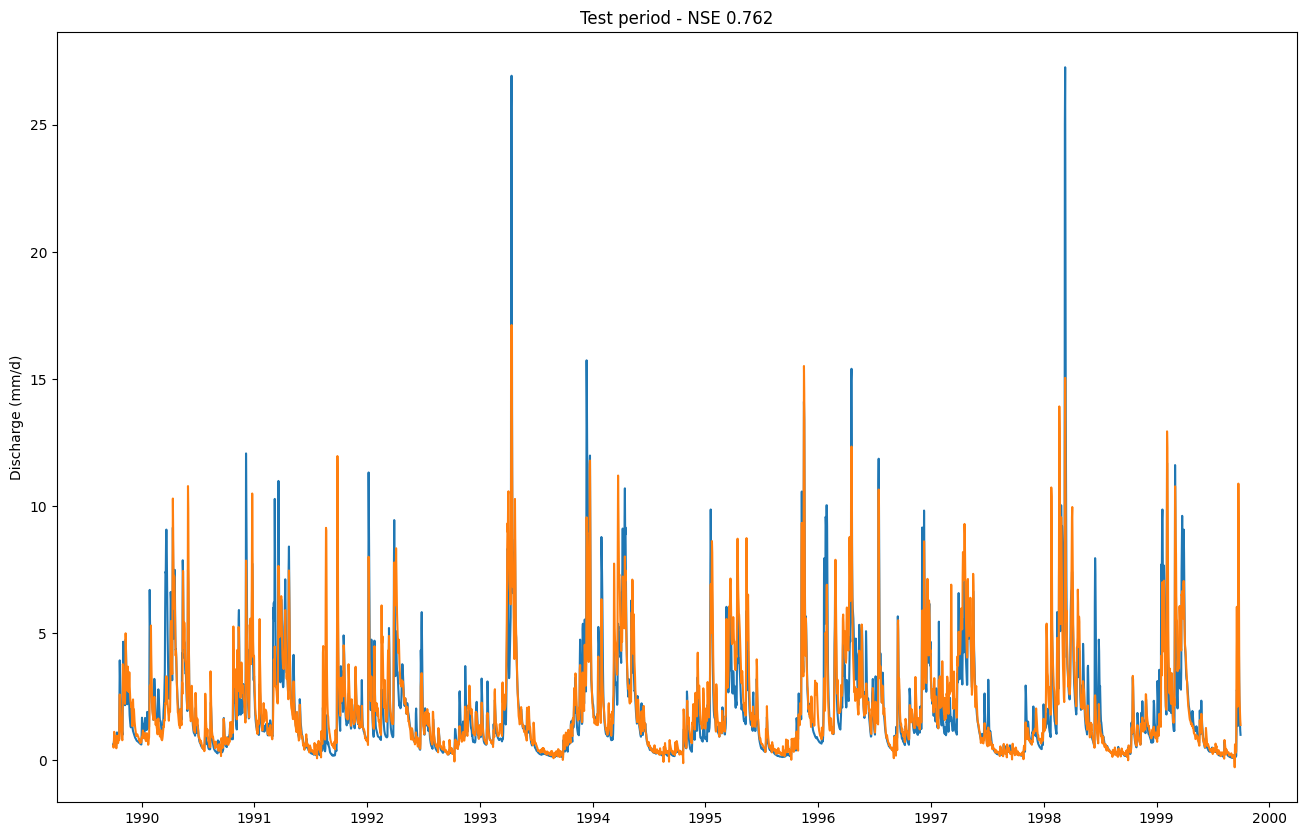

In [7]:
# extract observations and simulations
qobs = results['01022500']['1D']['xr']['QObs(mm/d)_obs']
qsim = results['01022500']['1D']['xr']['QObs(mm/d)_sim']

fig, ax = plt.subplots(figsize=(16,10))
ax.plot(qobs['date'], qobs)
ax.plot(qsim['date'], qsim)
ax.set_ylabel("Discharge (mm/d)")
ax.set_title(f"Test period - NSE {results['01022500']['1D']['NSE']:.3f}")

Next, we are going to compute all metrics that are implemented in the NeuralHydrology package. You will find additional hydrological signatures implemented in `neuralhydrology.evaluation.signatures`.

In [8]:
values = metrics.calculate_all_metrics(qobs.isel(time_step=-1), qsim.isel(time_step=-1))
for key, val in values.items():
    print(f"{key}: {val:.3f}")

NSE: 0.762
MSE: 1.170
RMSE: 1.082
KGE: 0.848
Alpha-NSE: 0.930
Beta-KGE: 1.054
Beta-NSE: 0.049
Pearson-r: 0.876
FHV: -9.076
FMS: -2.166
FLV: -867.495
Peak-Timing: 0.043
Peak-MAPE: 30.042
